# Introduction

In this project, we plan to build a model from loan data **that will determine whether a person is eligible for a loan by examining the individual's information.** In this project, three algorithms, `Logistic Regression`, `KNN`, and `ANN`, are used separately, and the results of each will be examined separately, and a final conclusion will be made as to which algorithm performed better for this problem according to the metrics.

In [260]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

In [261]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix

def tune_threshold(y_true, y_proba, thresholds):
    results = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        results.append({
            'threshold': t,
            'precision': precision,
            'recall': recall,
            'FP': fp,
            'FN': fn
        })

    return results


# Data Understanding and Preprocessing

In this section, we first read the data and store it in a dataframe, and after a brief look at the data, we handle null values.

In [262]:
df_loan = pd.read_csv("../data/raw/loan.csv")
display(df_loan.head())
df_loan.isna().sum()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [263]:
# Handling missing values
for col in df_loan.columns:
    if df_loan[col].dtype == 'object':
        df_loan.fillna({col: df_loan[col].mode()[0]}, inplace=True)
    else:
        df_loan.fillna({col: df_loan[col].median()}, inplace=True)
display(df_loan.isna().sum())
df_loan.head()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


We used the mode strategy here for the string value columns because it can be the most appropriate way to fill the string data, given the data distribution.
And for the numeric data, the median was used because using the mean could be quite problematic due to the presence of outlier data, especially in the columns related to income data.

In [264]:
# Encoding categorical variables
df_loan = pd.get_dummies(df_loan, drop_first=True)
df_loan.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,5849,0.0,128.0,360.0,1.0,True,False,False,False,False,False,False,False,True,True
1,4583,1508.0,128.0,360.0,1.0,True,True,True,False,False,False,False,False,False,False
2,3000,0.0,66.0,360.0,1.0,True,True,False,False,False,False,True,False,True,True
3,2583,2358.0,120.0,360.0,1.0,True,True,False,False,False,True,False,False,True,True
4,6000,0.0,141.0,360.0,1.0,True,False,False,False,False,False,False,False,True,True


Well, of course, since the machine learning models we are discussing have no understanding of non-numeric data, we use this short and simple but very useful command to convert our categorical string values ​​into `one-hot encoding` and make the data understandable to the model.

# Train, Validation and Test Split

In this section, considering the **supervised nature of the algorithm** and the **labeled data**, we separate the `X` and `y` data and then split the data related to **train**, **validation**, and **test**.

In [265]:
X = df_loan.drop('Loan_Status_Y', axis=1)
y = df_loan['Loan_Status_Y']

X_temp , X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1875, random_state=42, stratify=y_temp)

In the current state, 65% of our data is divided for model training, 15% for model validation, and 20% for model testing.

# Model Training with Pipeline and Scaling

In this section, we create a `pipeline` for each algorithm that takes care of data scaling and model building, and then we use `grid search` to find the best model parameters.

LogisticRegression Validation Precision Score: 0.8367346938775511
Accuracy: 0.6666666666666666


Text(50.722222222222214, 0.5, 'Actual')

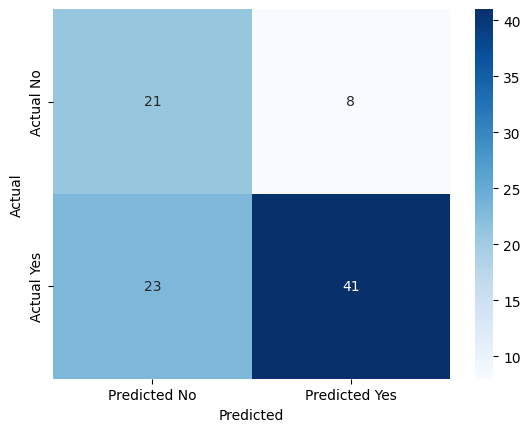

In [266]:
# Logistic Regression with scaler
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 3, 1: 1}))
])

param_grid_lr = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'lbfgs'],
    'model__class_weight': [{0: 1, 1: 1}, {0: 2, 1: 1}, {0: 3, 1: 1}]
}

grid_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    cv=5,
    scoring='precision',
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

best_model_lr = grid_lr.best_estimator_

y_val_pred_lr = best_model_lr.predict(X_val)
y_proba_lr = best_model_lr.predict_proba(X_val)[:, 1]
y_val_pred_lr = (y_proba_lr >= 0.5).astype(int)

print("LogisticRegression Validation Precision Score:", precision_score(y_val, y_val_pred_lr))
print("Accuracy:", accuracy_score(y_val, y_val_pred_lr))

mat = confusion_matrix(y_val, y_val_pred_lr)
sns.heatmap(
    mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted No', 'Predicted Yes'],
    yticklabels=['Actual No', 'Actual Yes']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')

LogisticRegression Validation Precision Score: 0.8088235294117647
Accuracy: 0.7634408602150538


Text(50.722222222222214, 0.5, 'Actual')

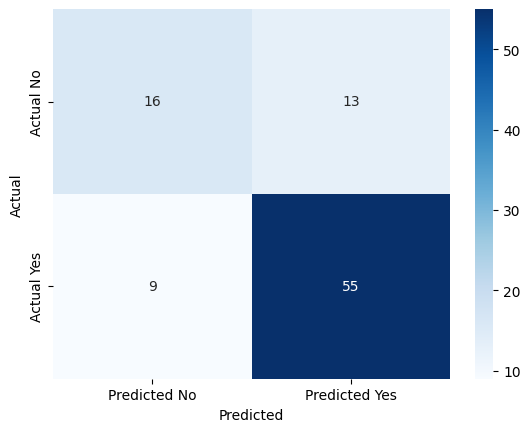

In [267]:
# KNN with scaler
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
])

param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9],
    'model__weights': ['uniform', 'distance'],
}

grid_knn = GridSearchCV(
    pipe_knn,
    param_grid_knn,
    cv=5,
    scoring='precision_macro',
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)

best_model_knn = grid_knn.best_estimator_

calibrated_knn = CalibratedClassifierCV(best_model_knn, method='isotonic', cv=5)
calibrated_knn.fit(X_train, y_train)

y_val_pred_knn = grid_knn.predict(X_val)
y_proba_knn = calibrated_knn.predict_proba(X_val)[:, 1]

y_val_pred_knn = (y_proba_knn >= 0.68).astype(int)

print("LogisticRegression Validation Precision Score:", precision_score(y_val, y_val_pred_knn))
print("Accuracy:", accuracy_score(y_val, y_val_pred_knn))

mat = confusion_matrix(y_val, y_val_pred_knn)
sns.heatmap(
    mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted No', 'Predicted Yes'],
    yticklabels=['Actual No', 'Actual Yes']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')

c:\Users\MORVARIDCO\Desktop\Projects\FinalProject_Daneshkar\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\MORVARIDCO\Desktop\Projects\FinalProject_Daneshkar\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\MORVARIDCO\Desktop\Projects\FinalProject_Daneshkar\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\MORVARIDCO\Desktop\Projects\FinalProject_Daneshkar\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: M

LogisticRegression Validation Precision Score: 0.7931034482758621
Accuracy: 0.6774193548387096


c:\Users\MORVARIDCO\Desktop\Projects\FinalProject_Daneshkar\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Text(50.722222222222214, 0.5, 'Actual')

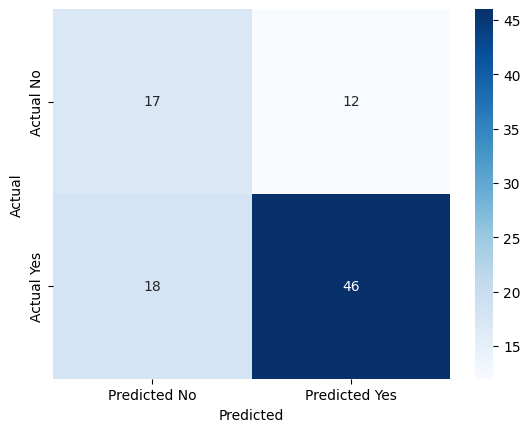

In [268]:
# ANN with scaler
pipe_ann = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPClassifier(random_state=42, max_iter=500))
])

param_grid_ann = {
    'model__hidden_layer_sizes': [(32,), (64, 32)],
    'model__alpha': [0.001, 0.01],
    'model__activation': ['relu', 'tanh'],
    'model__learning_rate_init': [0.001, 0.01]
}

grid_ann = GridSearchCV(
    pipe_ann,
    param_grid_ann,
    cv=5,
    scoring='precision_macro',
    n_jobs=-1
)

grid_ann.fit(X_train, y_train)

best_model_ann = grid_ann.best_estimator_

calibrated_ann = CalibratedClassifierCV(best_model_ann, method='isotonic', cv=5)
calibrated_ann.fit(X_train, y_train)

y_val_pred_ann = grid_ann.predict(X_val)
y_proba_ann = calibrated_ann.predict_proba(X_val)[:, 1]

y_val_pred_ann = (y_proba_ann >= 0.74).astype(int)

print("LogisticRegression Validation Precision Score:", precision_score(y_val, y_val_pred_ann))
print("Accuracy:", accuracy_score(y_val, y_val_pred_ann))

mat = confusion_matrix(y_val, y_val_pred_ann)
sns.heatmap(
    mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted No', 'Predicted Yes'],
    yticklabels=['Actual No', 'Actual Yes']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Threshold tuning and FP/FN analysis

In this section we vary the decision threshold for each trained model and visualize how False Positives (FP) and False Negatives (FN) change with the threshold. This helps to choose a threshold that controls risk (e.g., reduce FP) while considering the trade-off with FN.

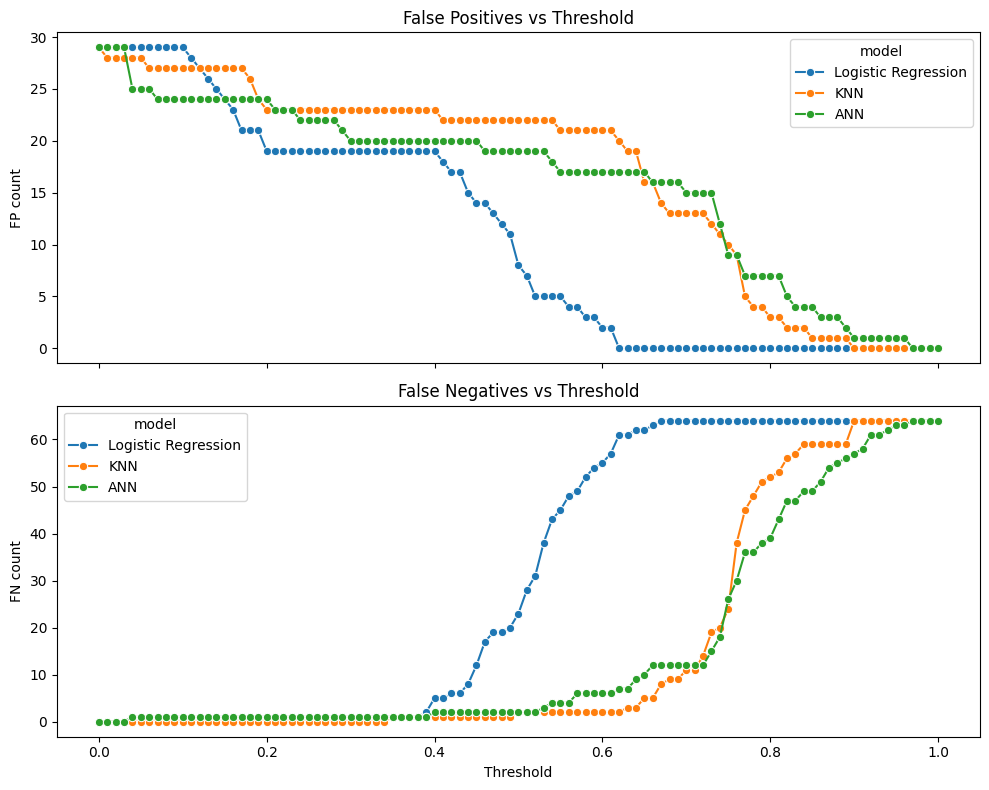

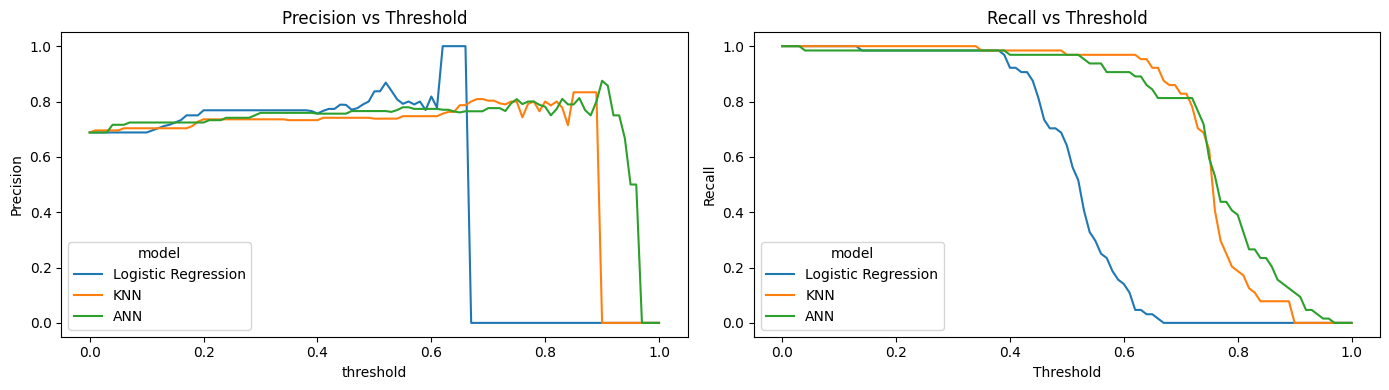

,model,threshold_min_FP_plus_FN,FP_at_this,FN_at_this,threshold_max_precision,precision_at_this
0,Logistic Regression,0.20,19,1,0.62,1.000000
1,KNN,0.65,16,5,0.85,0.833333
2,ANN,0.30,20,1,0.90,0.875000


In [269]:
# thresholds to evaluate
thresholds = np.linspace(0.0, 1.0, 101)

# get predicted probabilities for positive class for each model
# Logistic Regression
y_proba_lr = best_model_lr.predict_proba(X_val)[:, 1]
# KNN (calibrated)
# y_proba_knn already computed in the KNN cell (calibrated_knn predicted & thresholded there)
# ANN (calibrated)
# y_proba_ann already computed in the ANN cell

res_lr = pd.DataFrame(tune_threshold(y_val, y_proba_lr, thresholds))
res_knn = pd.DataFrame(tune_threshold(y_val, y_proba_knn, thresholds))
res_ann = pd.DataFrame(tune_threshold(y_val, y_proba_ann, thresholds))

res_lr['model'] = 'Logistic Regression'
res_knn['model'] = 'KNN'
res_ann['model'] = 'ANN'

res_all = pd.concat([res_lr, res_knn, res_ann], ignore_index=True)

# Plot FP and FN vs Threshold (two subplots)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

sns.lineplot(ax=axes[0], data=res_all, x='threshold', y='FP', hue='model', marker='o')
axes[0].set_title('False Positives vs Threshold')
axes[0].set_ylabel('FP count')

sns.lineplot(ax=axes[1], data=res_all, x='threshold', y='FN', hue='model', marker='o')
axes[1].set_title('False Negatives vs Threshold')
axes[1].set_ylabel('FN count')
axes[1].set_xlabel('Threshold')

plt.tight_layout()
plt.show()

# Also plot precision & recall vs threshold to visualize trade-offs
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.lineplot(ax=axes[0], data=res_all, x='threshold', y='precision', hue='model')
axes[0].set_title('Precision vs Threshold')
axes[0].set_ylabel('Precision')

sns.lineplot(ax=axes[1], data=res_all, x='threshold', y='recall', hue='model')
axes[1].set_title('Recall vs Threshold')
axes[1].set_ylabel('Recall')
axes[1].set_xlabel('Threshold')

plt.tight_layout()
plt.show()

# Summary: suggest candidate thresholds per model
summary = []
for name, df in [('Logistic Regression', res_lr), ('KNN', res_knn), ('ANN', res_ann)]:
    idx_min_sum = (df['FP'] + df['FN']).idxmin()
    t_min_sum = df.loc[idx_min_sum, 'threshold']
    idx_max_prec = df['precision'].idxmax()
    t_max_prec = df.loc[idx_max_prec, 'threshold']
    summary.append({
        'model': name,
        'threshold_min_FP_plus_FN': t_min_sum,
        'FP_at_this': df.loc[idx_min_sum, 'FP'],
        'FN_at_this': df.loc[idx_min_sum, 'FN'],
        'threshold_max_precision': t_max_prec,
        'precision_at_this': df.loc[idx_max_prec, 'precision']
    })

pd.DataFrame(summary)


**Due to the high cost of false positives, the focus of the model shifted from maximizing accuracy to controlling risk through precision, class weight adjustment, and threshold adjustment.**

# Model Evaluation

# Final Comparison

# Final Result and Insight